# 1. Recolha e Preparação de dados

In [1]:
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.window import *
import pandas as pd
import matplotlib.pyplot as plt

client = MongoClient('mongodb://mongodb:27017/')
db = client.projeto
c_atrasos = db.atrasos
c_voos = db.voos

print(c_atrasos.find_one())
print(c_voos.find_one())

client.close()

{'_id': ObjectId('676ed62b177c65a442d95605'), 'year': 2023, 'month': 8, 'carrier': '9E', 'carrier_name': 'Endeavor Air Inc.', 'airport': 'ABE', 'airport_name': 'Allentown/Bethlehem/Easton, PA: Lehigh Valley International', 'arr_flights': 89.0, 'arr_del15': 13.0, 'carrier_ct': 2.25, 'weather_ct': 1.6, 'nas_ct': 3.16, 'security_ct': 0.0, 'late_aircraft_ct': 5.99, 'arr_cancelled': 2.0, 'arr_diverted': 1.0, 'arr_delay': 1375.0, 'carrier_delay': 71.0, 'weather_delay': 761.0, 'nas_delay': 118.0, 'security_delay': 0.0, 'late_aircraft_delay': 425.0}
{'_id': ObjectId('676ef5e70a6bf8a76f22671a'), 'Unnamed: 0': 6256560, 'ItinID': 201835057271, 'MktID': 20183505727101, 'MktCoupons': 1, 'Quarter': 3, 'Origin': 'MCO', 'OriginWac': 33, 'Dest': 'BWI', 'DestWac': 35, 'Miles': 787.0, 'ContiguousUSA': 2, 'NumTicketsOrdered': 2.0, 'AirlineCompany': 'WN', 'PricePerTicket': 96.0}


In [2]:
spark = SparkSession.builder \
    .appName("Voos e atrasos em 2018") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/projeto") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/projeto") \
    .getOrCreate()

df_atrasos = spark.read.format("mongo").option("collection", "atrasos").load()
df_voos = spark.read.format("mongo").option("collection", "voos").load()

In [3]:
print(df_atrasos.printSchema())
print(df_voos.printSchema())

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- arr_cancelled: double (nullable = true)
 |-- arr_del15: double (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- arr_diverted: double (nullable = true)
 |-- arr_flights: double (nullable = true)
 |-- carrier: string (nullable = true)
 |-- carrier_ct: double (nullable = true)
 |-- carrier_delay: double (nullable = true)
 |-- carrier_name: string (nullable = true)
 |-- late_aircraft_ct: double (nullable = true)
 |-- late_aircraft_delay: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- nas_ct: double (nullable = true)
 |-- nas_delay: double (nullable = true)
 |-- security_ct: double (nullable = true)
 |-- security_delay: double (nullable = true)
 |-- weather_ct: double (nullable = true)
 |-- weather_delay: double (nullable = true)
 |-- year: integer (nullable = true)

None
root
 |-- AirlineC

In [4]:
df_atrasos = df_atrasos.drop("carrier","airport_name","carrier_ct","weather_ct","nas_ct","security_ct","late_aircraft_ct","arr_diverted","carrier_delay","weather_delay","nas_delay","security_delay","late_aircraft_delay", "_id")
df_atrasos = df_atrasos.filter(df_atrasos["year"] == 2018)
df_atrasos = df_atrasos.filter((df_atrasos["month"] >= 7) & (df_atrasos["month"] <= 9))

df_atrasos = df_atrasos.dropna()

df_atrasos = df_atrasos.dropDuplicates()

null_atrasos = df_atrasos.select([count(when(col(c).isNull(), c)).alias(c) for c in df_atrasos.columns])

null_atrasos.show()
df_atrasos.count()

+-------+-------------+---------+---------+-----------+------------+-----+----+
|airport|arr_cancelled|arr_del15|arr_delay|arr_flights|carrier_name|month|year|
+-------+-------------+---------+---------+-----------+------------+-----+----+
|      0|            0|        0|        0|          0|           0|    0|   0|
+-------+-------------+---------+---------+-----------+------------+-----+----+



5072

In [5]:
df_voos = df_voos.drop("ItinID","MktID","MktCoupons","ContiguousUSA","NumTicketsOrdered","AirlineCompany", "_id", "Unnamed: 0")
df_voos = df_voos.toDF(*[col.lower() for col in df_voos.columns])

df_voos = df_voos.dropna()

df_voos = df_voos.dropDuplicates()

null_voos = df_voos.select([count(when(col(c).isNull(), c)).alias(c) for c in df_voos.columns])

null_voos.show()
df_voos.count()

+----+-------+-----+------+---------+--------------+-------+
|dest|destwac|miles|origin|originwac|priceperticket|quarter|
+----+-------+-----+------+---------+--------------+-------+
|   0|      0|    0|     0|        0|             0|      0|
+----+-------+-----+------+---------+--------------+-------+



229725

In [6]:
df_atrasos = df_atrasos.withColumn("index", monotonically_increasing_id())

window_spec = Window.orderBy("airport")

df_atrasos = df_atrasos.withColumn("index", row_number().over(window_spec) - 1)

In [7]:
print(df_atrasos.printSchema())
print(df_voos.printSchema())

root
 |-- airport: string (nullable = true)
 |-- arr_cancelled: double (nullable = true)
 |-- arr_del15: double (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- arr_flights: double (nullable = true)
 |-- carrier_name: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- index: integer (nullable = false)

None
root
 |-- dest: string (nullable = true)
 |-- destwac: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- origin: string (nullable = true)
 |-- originwac: integer (nullable = true)
 |-- priceperticket: double (nullable = true)
 |-- quarter: integer (nullable = true)

None


# 2. Análise exploratória

#### Os cinco aeroportos com mais atrasos de 15+ minutos

In [8]:
top5_delays = (
    df_atrasos.groupBy("airport")
    .agg(sum("arr_del15").alias("total_delays"))
    .orderBy(col("total_delays").desc())
    .limit(5)
)

top5_delays.show()

+-------+------------+
|airport|total_delays|
+-------+------------+
|    ORD|     19543.0|
|    ATL|     15905.0|
|    DFW|     15661.0|
|    EWR|     11931.0|
|    SFO|     11763.0|
+-------+------------+



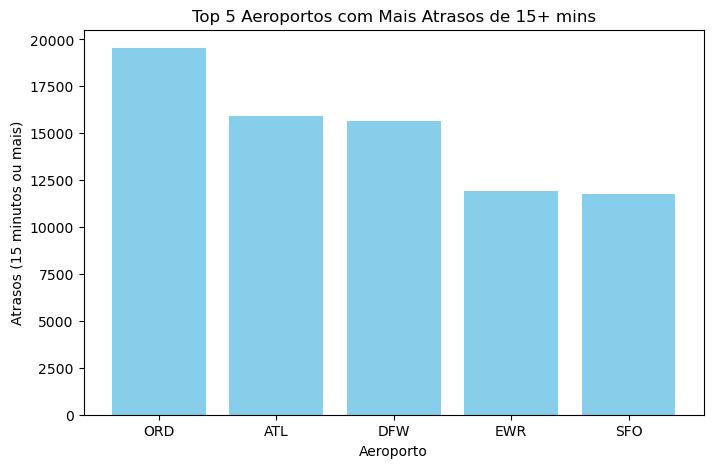

In [9]:
top5_delays_pandas = top5_delays.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(top5_delays_pandas["airport"], top5_delays_pandas["total_delays"], color="skyblue")
plt.xlabel("Aeroporto")
plt.ylabel("Atrasos (15 minutos ou mais)")
plt.title("Top 5 Aeroportos com Mais Atrasos de 15+ mins")
plt.show()

Concluimos então que os aeroportos com maior quantidade de atrasos significativos são: 
-ORD: Chicago, IL: Chicago O'Hare International\
-ATL: Atlanta, GA: Hartsfield-Jackson Atlanta International\
-DFW: Dallas/Fort Worth, TX: Dallas/Fort Worth International\
-EWR: Newark, NJ: Newark Liberty International\
-SFO: San Francisco, CA: San Francisco International

Estes atrasos podem dever-se a fatores como alto volume de tráfego, condições climatéricas adversas recorrentes ou a complexidade operacional.

#### Média de preços para os aeroportos com mais atrasos

preço médio dos bilhetes

In [10]:
preco_medio = df_voos.select(avg("PricePerTicket").alias("PrecoMedio")).collect()[0]["PrecoMedio"]

print(f"O preço médio dos bilhetes é: {preco_medio:.2f}")

O preço médio dos bilhetes é: 231.92


In [11]:
most_delayed_airports = [row["airport"] for row in top5_delays.collect()]

filtered_df = df_voos.filter(df_voos["Dest"].isin(most_delayed_airports))

average_prices = (
    filtered_df.groupBy("Dest")
    .agg(round(avg("PricePerTicket"), 2).alias("AveragePrice"))
)

average_prices.show()

+----+------------+
|Dest|AveragePrice|
+----+------------+
| EWR|      277.48|
| DFW|      259.76|
| SFO|      294.81|
| ATL|      238.68|
| ORD|      249.66|
+----+------------+



É possível concluir, que devido à afluência e importância dos aeroportos acima especificados, mesmo apresentando bastantes atrasos significativos, os preços mantêm-se acima da média

#### Aeroportos com mais voos cancelados por percentagem

In [12]:
grouped = (
    df_atrasos.groupBy("airport")
    .agg(
        sum("arr_flights").alias("total_flights"),
        sum("arr_cancelled").alias("total_cancelled")
    )
)

grouped = grouped.withColumn(
    "cancelled_percentage",
    round((col("total_cancelled") / col("total_flights")) * 100, 2)
)

top_cancelled = grouped.orderBy(col("cancelled_percentage").desc()).limit(10)

top_cancelled.select("airport", "cancelled_percentage").show()

+-------+--------------------+
|airport|cancelled_percentage|
+-------+--------------------+
|    OGS|               14.29|
|    PGV|                9.73|
|    HVN|                8.98|
|    OAJ|                8.55|
|    ILM|                8.13|
|    EWN|                7.47|
|    ASE|                6.19|
|    FAY|                5.53|
|    DLG|                5.36|
|    CHS|                5.33|
+-------+--------------------+



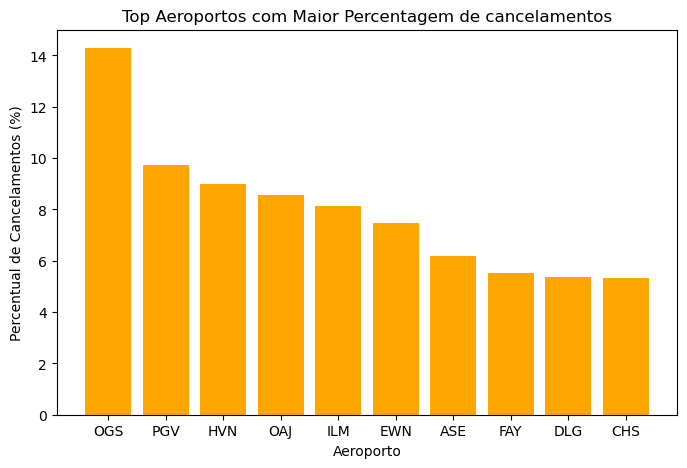

In [13]:
top_cancelled_pandas = top_cancelled.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(top_cancelled_pandas["airport"], top_cancelled_pandas["cancelled_percentage"], color="orange")
plt.xlabel("Aeroporto")
plt.ylabel("Percentual de Cancelamentos (%)")
plt.title("Top Aeroportos com Maior Percentagem de cancelamentos")
plt.show()

Como podemos analisar, o aeroporto de Ogdensburg, NY: Ogdensburg International (OGS), apresenta uma percentagem de cancelamentos bastante elevada, comparando com os restantes. Alguns dos motivos pelos quais isto acontece podem ser, o clima adverso, recusos operacionais limitados, dependência de conexões, e baixa demanda, Todos estes fatores tornam aeroportos menores, como o OGS, mais vulneráveis a cancelamentos de voos.


In [14]:
top_airports = [row["airport"] for row in top_cancelled.collect()]

# Filtrar o DataFrame de voos para incluir apenas os aeroportos mais cancelados
filtered_voos = df_voos.filter(col("Dest").isin(top_airports))

# Agrupar pelo aeroporto e calcular a média do preço dos bilhetes
preco_medio_por_aeroporto = (
    filtered_voos.groupBy("Dest")
    .agg(round(avg("PricePerTicket"), 2).alias("AveragePricePerTicket"))
)

# Exibir o resultado
preco_medio_por_aeroporto.show()

+----+---------------------+
|Dest|AveragePricePerTicket|
+----+---------------------+
| DLG|                229.4|
| OGS|                89.05|
| CHS|               194.78|
| FAY|                221.2|
| ILM|               254.68|
| ASE|                263.0|
+----+---------------------+



-ASE: Aspen, CO: Aspen Pitkin County Sardy Field \
-CHS: Charleston, SC: Charleston AFB/International\
-DLG: Dillingham, AK: Dillingham Airport\
-FAY: Fayetteville, NC: Fayetteville Regional/Grannis Field\
-ILM: Wilmington, NC: Wilmington International\
-OGS: Ogdensburg, NY: Ogdensburg International

Concluimos assim, para os aeroportos onde encontramos uma correpondencia, que a maior parte mantém um preço bastante próximo da média, devido a todos os motivos refiridos anteriormente

# 3. Processamento e Análise Avançada:

#### Taxa de Cancelamento por Aeroporto vs. Preço Médio por Destino

In [15]:
df_atrasos_taxa = df_atrasos.groupBy("airport").agg(
    round((sum("arr_cancelled") / sum("arr_flights") * 100), 2).alias("cancel_rate")
)
df_atrasos_taxa = df_atrasos_taxa.orderBy("cancel_rate", ascending=False)
df_atrasos_taxa.show(5)

+-------+-----------+
|airport|cancel_rate|
+-------+-----------+
|    OGS|      14.29|
|    PGV|       9.73|
|    HVN|       8.98|
|    OAJ|       8.55|
|    ILM|       8.13|
+-------+-----------+
only showing top 5 rows



In [16]:
df_voos_preco = df_voos.groupBy("dest").agg(
    round(avg("priceperticket"), 2).alias("avg_price")
)
df_voos_preco = df_voos_preco.orderBy("avg_price", ascending=False)
df_voos_preco.show(5)

+----+---------+
|dest|avg_price|
+----+---------+
| ADK|    622.5|
| PPG|   613.56|
| PHF|    507.0|
| GST|   397.56|
| EGE|   381.17|
+----+---------+
only showing top 5 rows



In [17]:
df_comb = df_voos_preco.join(df_atrasos_taxa, df_voos_preco.dest == df_atrasos_taxa.airport, "inner")

df_comb = df_comb.drop("airport")
df_comb = df_comb.orderBy("avg_price", ascending=False)
df_comb.show(5)

+----+---------+-----------+
|dest|avg_price|cancel_rate|
+----+---------+-----------+
| ADK|    622.5|        0.0|
| PPG|   613.56|        0.0|
| PHF|    507.0|       2.52|
| GST|   397.56|       3.57|
| EGE|   381.17|       0.77|
+----+---------+-----------+
only showing top 5 rows



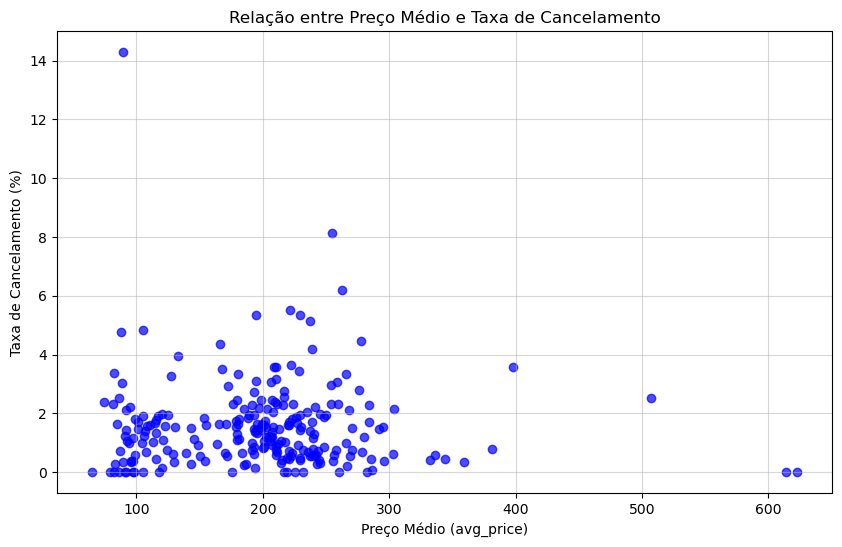

In [20]:
df_comb_pd = df_comb.select("dest", "avg_price", "cancel_rate").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_comb_pd["avg_price"], df_comb_pd["cancel_rate"], color="blue", alpha=0.7)
plt.title("Relação entre Preço Médio e Taxa de Cancelamento")
plt.xlabel("Preço Médio (avg_price)")
plt.ylabel("Taxa de Cancelamento (%)")
plt.grid(alpha=0.5)
plt.show()

#### Número de Voos por Origem vs. Taxa de Cancelamento por Aeroporto

In [21]:
df_voos_count = df_voos.groupBy("origin").agg(
    count("*").alias("num_flights")
)
df_voos_count.show(5)

+------+-----------+
|origin|num_flights|
+------+-----------+
|   PSE|         80|
|   DLG|          9|
|   MSY|       2661|
|   PPG|          8|
|   GEG|        522|
+------+-----------+
only showing top 5 rows



In [22]:
df_comb_voos_canc = df_voos_count.join(df_atrasos_taxa, df_voos_count.origin == df_atrasos_taxa.airport, "inner")

df_comb_voos_canc = df_comb_voos_canc.drop("airport")
df_comb_voos_canc = df_comb_voos_canc.orderBy("cancel_rate", ascending=False)
df_comb_voos_canc.show(5)

+------+-----------+-----------+
|origin|num_flights|cancel_rate|
+------+-----------+-----------+
|   OGS|         10|      14.29|
|   ILM|         43|       8.13|
|   FAY|          9|       5.53|
|   DLG|          9|       5.36|
|   CHS|        797|       5.33|
+------+-----------+-----------+
only showing top 5 rows



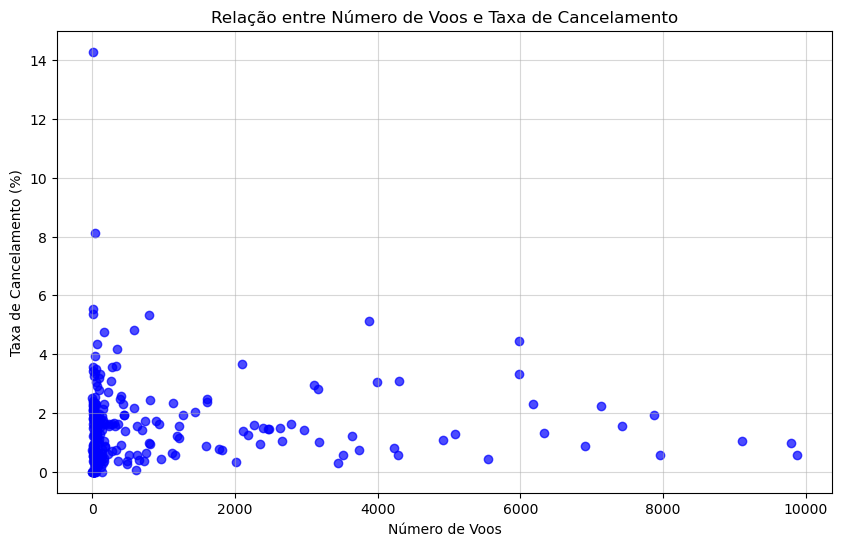

In [23]:
df_comb_voos_canc_pd = df_comb_voos_canc.select("origin", "cancel_rate", "num_flights").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_comb_voos_canc_pd["num_flights"], df_comb_voos_canc_pd["cancel_rate"], alpha=0.7, color="blue")
plt.title("Relação entre Número de Voos e Taxa de Cancelamento")
plt.xlabel("Número de Voos")
plt.ylabel("Taxa de Cancelamento (%)")
plt.grid(alpha=0.5)
plt.show()

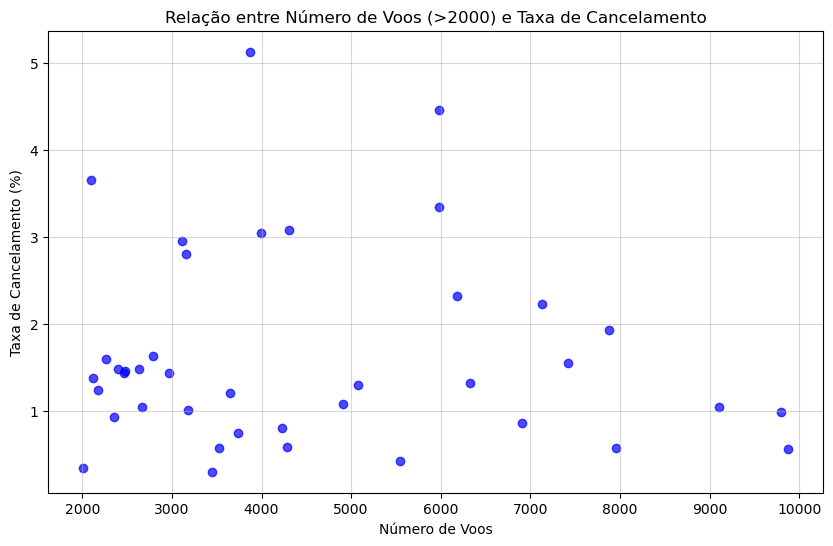

In [24]:
df_2000 = df_comb_voos_canc_pd[df_comb_voos_canc_pd["num_flights"] > 2000]

plt.figure(figsize=(10, 6))
plt.scatter(df_2000["num_flights"], df_2000["cancel_rate"], alpha=0.7, color="blue")
plt.title("Relação entre Número de Voos (>2000) e Taxa de Cancelamento")
plt.xlabel("Número de Voos")
plt.ylabel("Taxa de Cancelamento (%)")
plt.grid(alpha=0.5)
plt.show()

#### Média de Atraso por Aeroporto vs. Distância Média por Origem

In [25]:
df_atrasos_delay = df_atrasos.groupBy("airport").agg(
    round(avg("arr_delay"), 2).alias("avg_arr_delay")
)

df_atrasos_delay = df_atrasos_delay.orderBy("avg_arr_delay", ascending=False)
df_atrasos_delay.show(5)

+-------+-------------+
|airport|avg_arr_delay|
+-------+-------------+
|    ORD|      40906.1|
|    SFO|     31594.54|
|    DFW|     30801.33|
|    JFK|     30062.08|
|    EWR|     27305.18|
+-------+-------------+
only showing top 5 rows



In [26]:
df_voos_distance = df_voos.groupBy("origin").agg(
    round(avg("miles"), 2).alias("avg_distance")
)

df_voos_distance = df_voos_distance.orderBy("avg_distance", ascending=False)
df_voos_distance.show(5)

+------+------------+
|origin|avg_distance|
+------+------------+
|   PPG|      2599.0|
|   HNL|     2520.66|
|   OGG|     2195.47|
|   KOA|     2030.66|
|   LIH|     2027.98|
+------+------------+
only showing top 5 rows



In [27]:
df_comb_distance_delay = df_voos_distance.join(df_atrasos_delay, df_voos_distance.origin == df_atrasos_delay.airport, "inner")

df_comb_distance_delay = df_comb_distance_delay.orderBy("avg_distance", ascending=False)
df_comb_distance_delay.select("origin", "avg_distance", "avg_arr_delay").show(5)

+------+------------+-------------+
|origin|avg_distance|avg_arr_delay|
+------+------------+-------------+
|   PPG|      2599.0|         26.0|
|   HNL|     2520.66|      4457.86|
|   OGG|     2195.47|      2238.64|
|   KOA|     2030.66|       990.86|
|   LIH|     2027.98|       842.29|
+------+------------+-------------+
only showing top 5 rows



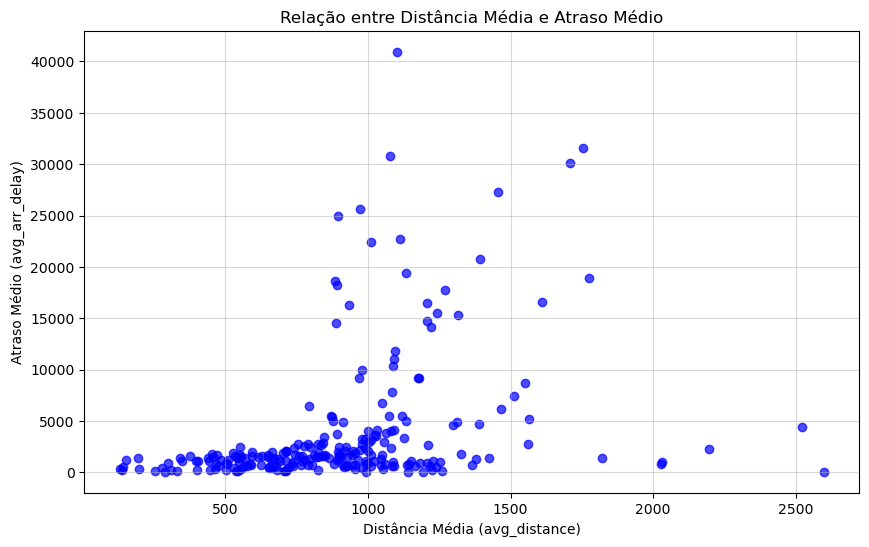

In [28]:
df_comb_distance_delay_pd = df_comb_distance_delay.select("avg_distance", "avg_arr_delay").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_comb_distance_delay_pd["avg_distance"], df_comb_distance_delay_pd["avg_arr_delay"], alpha=0.7, color="blue")
plt.title("Relação entre Distância Média e Atraso Médio")
plt.xlabel("Distância Média (avg_distance)")
plt.ylabel("Atraso Médio (avg_arr_delay)")
plt.grid(alpha=0.5)
plt.show()